In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # https://plotly.com/python/
from pprint import pprint
import plotly.graph_objs as go
# from statistics import mode, mean, median

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn import svm
from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier

## Parte 1: Preparação dos dados

In [ ]:
df = pd.read_csv('frequency_parameters.csv', sep=',')


In [ ]:
df.head

<bound method NDFrame.head of      FP1_THETA  FP1_ALFA  ...  A2-A1_GAMMA  target_class
0     0.003122  0.000746  ...     0.000132           0.0
1     0.003605  0.000666  ...     0.000147           0.0
2     0.003238  0.000703  ...     0.000127           0.0
3     0.002924  0.000697  ...     0.000156           0.0
4     0.002708  0.000764  ...     0.000164           0.0
..         ...       ...  ...          ...           ...
275   0.017603  0.001304  ...     0.000594           1.0
276   0.012351  0.001250  ...     0.000272           1.0
277   0.010578  0.001124  ...     0.000335           1.0
278   0.008294  0.000932  ...     0.000323           1.0
279   0.011787  0.001186  ...     0.000355           1.0

[280 rows x 101 columns]>

In [ ]:
df.iloc[:,:]

,FP1_THETA,FP1_ALFA,FP1_LOW_BETA,FP1_HIGH_BETA,FP1_GAMMA,FP2_THETA,FP2_ALFA,FP2_LOW_BETA,FP2_HIGH_BETA,FP2_GAMMA,F3_THETA,F3_ALFA,F3_LOW_BETA,F3_HIGH_BETA,F3_GAMMA,F4_THETA,F4_ALFA,F4_LOW_BETA,F4_HIGH_BETA,F4_GAMMA,F7_THETA,F7_ALFA,F7_LOW_BETA,F7_HIGH_BETA,F7_GAMMA,F8_THETA,F8_ALFA,F8_LOW_BETA,F8_HIGH_BETA,F8_GAMMA,T3_THETA,T3_ALFA,T3_LOW_BETA,T3_HIGH_BETA,T3_GAMMA,T4_THETA,T4_ALFA,T4_LOW_BETA,T4_HIGH_BETA,T4_GAMMA,...,P3_ALFA,P3_LOW_BETA,P3_HIGH_BETA,P3_GAMMA,P4_THETA,P4_ALFA,P4_LOW_BETA,P4_HIGH_BETA,P4_GAMMA,O1_THETA,O1_ALFA,O1_LOW_BETA,O1_HIGH_BETA,O1_GAMMA,O2_THETA,O2_ALFA,O2_LOW_BETA,O2_HIGH_BETA,O2_GAMMA,FZ_THETA,FZ_ALFA,FZ_LOW_BETA,FZ_HIGH_BETA,FZ_GAMMA,CZ_THETA,CZ_ALFA,CZ_LOW_BETA,CZ_HIGH_BETA,CZ_GAMMA,PZ_THETA,PZ_ALFA,PZ_LOW_BETA,PZ_HIGH_BETA,PZ_GAMMA,A2-A1_THETA,A2-A1_ALFA,A2-A1_LOW_BETA,A2-A1_HIGH_BETA,A2-A1_GAMMA,target_class
0,0.003122,0.000746,0.001290,0.003108,0.000984,0.005411,0.001114,0.001699,0.003875,0.001397,0.007081,0.001243,0.002075,0.004681,0.001687,0.005092,0.001526,0.002358,0.004979,0.001751,0.013285,0.001435,0.001856,0.003119,0.001677,0.007875,0.001295,0.001836,0.003530,0.001795,0.008934,0.001348,0.002278,0.004970,0.001892,0.003524,0.001277,0.001832,0.004609,0.001419,...,0.001182,0.001713,0.006912,0.001667,0.004009,0.001435,0.002115,0.010475,0.001942,0.004973,0.001485,0.002685,0.008420,0.002087,0.004814,0.001740,0.004600,0.018207,0.002638,0.005512,0.001485,0.002350,0.004953,0.001717,0.005453,0.004913,0.002723,0.004240,0.001982,0.004638,0.001380,0.001883,0.007343,0.001822,0.000364,0.000256,0.000186,0.000429,0.000132,0.0
1,0.003605,0.000666,0.001151,0.003855,0.001076,0.006041,0.000956,0.001577,0.004728,0.001484,0.005199,0.001226,0.001922,0.006022,0.002006,0.005399,0.001502,0.002050,0.005927,0.001932,0.014417,0.001468,0.001560,0.004118,0.001599,0.007888,0.001246,0.001695,0.004136,0.001872,0.006925,0.001207,0.001996,0.004942,0.002118,0.005612,0.001127,0.001300,0.005156,0.001649,...,0.000994,0.001202,0.005752,0.001926,0.005782,0.001071,0.001407,0.009802,0.002030,0.005364,0.001086,0.001806,0.008943,0.002296,0.006755,0.001155,0.003045,0.024074,0.002835,0.005451,0.001478,0.002036,0.005918,0.001911,0.006511,0.004349,0.002591,0.005397,0.002185,0.006095,0.001058,0.001480,0.006026,0.001975,0.000437,0.000203,0.000169,0.000577,0.000147,0.0
2,0.003238,0.000703,0.001059,0.003332,0.001057,0.006116,0.001001,0.001324,0.004140,0.001483,0.004321,0.001103,0.001612,0.005074,0.001775,0.004820,0.001189,0.001907,0.005712,0.001838,0.012378,0.001539,0.001991,0.003163,0.001619,0.010413,0.001356,0.001481,0.003918,0.001762,0.008324,0.001123,0.002592,0.005189,0.002051,0.003411,0.000834,0.001318,0.005128,0.001504,...,0.000915,0.001321,0.005836,0.001688,0.004248,0.000947,0.001502,0.008389,0.001870,0.003866,0.000950,0.001317,0.005679,0.001984,0.005004,0.000986,0.001910,0.012841,0.002349,0.004606,0.001226,0.001920,0.005680,0.001798,0.005879,0.004560,0.002276,0.004939,0.002033,0.004761,0.000913,0.001415,0.006110,0.001771,0.000414,0.000258,0.000201,0.000497,0.000127,0.0
3,0.002924,0.000697,0.001280,0.003898,0.001035,0.005723,0.000899,0.001609,0.004823,0.001454,0.004187,0.001242,0.002095,0.006025,0.001800,0.004271,0.001320,0.002246,0.006477,0.001851,0.010359,0.001390,0.002052,0.003823,0.001610,0.005576,0.001145,0.001677,0.004644,0.001761,0.007544,0.001525,0.002410,0.004631,0.001822,0.004074,0.000970,0.001520,0.005759,0.001425,...,0.001277,0.001668,0.006309,0.001813,0.004276,0.001228,0.001840,0.011564,0.001965,0.004358,0.001231,0.002093,0.010676,0.002403,0.005381,0.001134,0.003777,0.029824,0.003036,0.004349,0.001334,0.002226,0.006431,0.001825,0.005601,0.004236,0.002740,0.005881,0.002097,0.004737,0.001361,0.001626,0.006907,0.001866,0.000388,0.000225,0.000208,0.000738,0.000156,0.0
4,0.002708,0.000764,0.001208,0.003596,0.001209,0.004032,0.000965,0.001529,0.004449,0.001588,0.004251,0.001402,0.001964,0.005743,0.002145,0.004798,0.001690,0.002125,0.006132,0.002167,0.011958,0.001320,0.001689,0.003542,0.001631,0.009049,0.001480,0.001732,0.004358,0.0

### Data Correlation

In [ ]:
df.corr()

,FP1_THETA,FP1_ALFA,FP1_LOW_BETA,FP1_HIGH_BETA,FP1_GAMMA,FP2_THETA,FP2_ALFA,FP2_LOW_BETA,FP2_HIGH_BETA,FP2_GAMMA,F3_THETA,F3_ALFA,F3_LOW_BETA,F3_HIGH_BETA,F3_GAMMA,F4_THETA,F4_ALFA,F4_LOW_BETA,F4_HIGH_BETA,F4_GAMMA,F7_THETA,F7_ALFA,F7_LOW_BETA,F7_HIGH_BETA,F7_GAMMA,F8_THETA,F8_ALFA,F8_LOW_BETA,F8_HIGH_BETA,F8_GAMMA,T3_THETA,T3_ALFA,T3_LOW_BETA,T3_HIGH_BETA,T3_GAMMA,T4_THETA,T4_ALFA,T4_LOW_BETA,T4_HIGH_BETA,T4_GAMMA,...,P3_ALFA,P3_LOW_BETA,P3_HIGH_BETA,P3_GAMMA,P4_THETA,P4_ALFA,P4_LOW_BETA,P4_HIGH_BETA,P4_GAMMA,O1_THETA,O1_ALFA,O1_LOW_BETA,O1_HIGH_BETA,O1_GAMMA,O2_THETA,O2_ALFA,O2_LOW_BETA,O2_HIGH_BETA,O2_GAMMA,FZ_THETA,FZ_ALFA,FZ_LOW_BETA,FZ_HIGH_BETA,FZ_GAMMA,CZ_THETA,CZ_ALFA,CZ_LOW_BETA,CZ_HIGH_BETA,CZ_GAMMA,PZ_THETA,PZ_ALFA,PZ_LOW_BETA,PZ_HIGH_BETA,PZ_GAMMA,A2-A1_THETA,A2-A1_ALFA,A2-A1_LOW_BETA,A2-A1_HIGH_BETA,A2-A1_GAMMA,target_class
FP1_THETA,1.000000,0.675700,0.296242,-0.016445,0.069708,0.599955,0.327981,0.155905,-0.122232,-0.094639,0.472738,0.294468,0.335791,-0.026476,-0.064451,0.416388,0.286147,0.279135,-0.064406,-0.087264,0.408791,0.329429,0.266749,-0.006038,-0.017592,0.346789,0.216319,0.075371,-0.135870,-0.147985,0.210118,-0.024499,0.183310,0.095177,-0.029667,0.293546,0.166292,0.197664,0.033303,0.008186,...,0.142449,0.183142,0.248049,0.059816,0.142113,0.162420,0.192979,0.218931,0.088625,-0.048484,-0.034559,0.016799,0.008207,-0.043979,0.054102,0.098454,0.058442,0.084517,0.014790,0.474705,0.265162,0.306789,-0.082461,-0.106241,0.116447,0.044006,0.295209,0.052996,-0.092373,0.115190,0.209439,0.187721,0.174801,0.152938,0.075388,0.250544,0.218135,0.098689,0.232739,0.223113
FP1_ALFA,0.675700,1.000000,0.486663,0.052658,0.136617,0.524570,0.681007,0.353953,-0.062006,0.139917,0.484065,0.592123,0.419865,-0.017157,0.128769,0.465694,0.603204,0.349137,-0.045606,0.128434,0.313851,0.561231,0.402012,0.028841,0.081792,0.450248,0.509576,0.290961,-0.062663,0.020667,0.249173,0.095821,0.226579,0.062242,0.084144,0.225102,0.192870,0.234058,-0.012095,0.010332,...,0.390557,0.211093,0.161568,0.179842,0.244788,0.364892,0.213230,0.111292,0.191622,0.093267,0.272759,0.074675,-0.039707,0.131637,0.147767,0.322475,0.093691,-0.020789,0.112322,0.456806,0.533735,0.389983,-0.054521,0.082643,0.230895,0.287773,0.297495,0.037278,0.096449,0.179129,0.356177,0.181737,0.066362,0.197990,0.175763,0.387682,0.201203,0.054445,0.258477,0.338637
FP1_LOW_BETA,0.296242,0.486663,1.000000,0.259450,0.198015,0.216722,0.343296,0.701525,0.074558,0.244789,0.173724,0.233816,0.734704,0.119341,0.228353,0.187117,0.281954,0.653698,0.053441,0.229597,0.105584,0.231768,0.714241,0.327151,0.117576,0.266110,0.277972,0.707476,0.078509,0.089651,0.134375,0.023109,0.484432,0.235003,0.201983,0.022498,0.041454,0.521910,0.037894,-0.025527,...,0.405187,0.575921,0.233250,0.364779,0.182711,0.399648,0.610787,0.216533,0.450355,0.069202,0.250364,0.558717,0.143552,0.417456,0.170294,0.294856,0.561592,0.089989,0.359377,0.120131,0.149841,0.717483,0.088364,0.197636,0.041143,0.167925,0.575286,0.193369,0.292018,0.211041,0.398502,0.580112,0.214635,0.394860,0.142324,0.185707,0.296755,0.170805,0.177365,-0.012981
FP1_HIGH_BETA,-0.016445,0.052658,0.259450,1.000000,0.408496,0.038439,0.085054,0.322827,0.848121,0.473591,0.083127,0.081642,0.192431,0.932058,0.639767,0.096487,0.103848,0.290306,0.851082,0.612782,0.118145,0.177984,0.288579,0.720500,0.486317,0.074130,0.097814,0.259477,0.896411,0.495276,0.082835,0.045986,0.328203,0.645378,0.461015,0.167174,0.124640,0.187474,0.694117,-0.002911,...,0.094102,0.164589,0.519046,0.616285,0.162877,0.182406,0.120653,0.609325,0.691115,0.082989,0.088320,0.104852,0.696908,0.682876,0.051194,0.108389,0.106603,0.773342,0.771015,0.057938,0.046632,0.155293,0.904995,0.619581,0.081314,0.251250,0.101892,0.822684,0.681701,0.087756,0.085389,0.082907,0.590388,0.646167,0.053939,0.104607,0.250794,0.590210,0.237683,-0.079482
FP1_GAMMA,0.069708,0.136617,0.198015,0.408496,1.000000,0.245420,0.409159,0.562876,0.675173,0.853516,0.258482,0.264275,0.097616,0.343989,0.510526,0.357093,0.169970,0.071530,0.22

### Correlation Threshold

In [ ]:
corrTab = df.corr()
hasWonCorr = corrTab[(corrTab['target_class'] > 0.1) | (corrTab['target_class'] < -0.1) ]
hasWonCorr = hasWonCorr['target_class']

varsImportant = hasWonCorr.index[1:]
varsImportant

Index(['FP1_ALFA', 'FP2_THETA', 'FP2_ALFA', 'F3_LOW_BETA', 'F3_HIGH_BETA',
       'F3_GAMMA', 'F4_LOW_BETA', 'F4_HIGH_BETA', 'F4_GAMMA', 'F7_THETA',
       'F7_ALFA', 'F7_LOW_BETA', 'F7_HIGH_BETA', 'F8_THETA', 'F8_ALFA',
       'F8_HIGH_BETA', 'T3_LOW_BETA', 'T3_HIGH_BETA', 'T4_LOW_BETA',
       'C3_LOW_BETA', 'C3_HIGH_BETA', 'C3_GAMMA', 'C4_THETA', 'C4_LOW_BETA',
       'C4_HIGH_BETA', 'C4_GAMMA', 'T5_LOW_BETA', 'T5_HIGH_BETA',
       'T6_LOW_BETA', 'T6_HIGH_BETA', 'P3_LOW_BETA', 'P3_HIGH_BETA', 'P4_ALFA',
       'P4_LOW_BETA', 'P4_HIGH_BETA', 'P4_GAMMA', 'O1_ALFA', 'O1_LOW_BETA',
       'O1_HIGH_BETA', 'O2_LOW_BETA', 'O2_HIGH_BETA', 'FZ_LOW_BETA',
       'FZ_HIGH_BETA', 'FZ_GAMMA', 'CZ_ALFA', 'CZ_LOW_BETA', 'CZ_HIGH_BETA',
       'CZ_GAMMA', 'PZ_ALFA', 'PZ_LOW_BETA', 'PZ_HIGH_BETA', 'PZ_GAMMA',
       'A2-A1_ALFA', 'A2-A1_GAMMA', 'target_class'],
      dtype='object')

### Count Classes

25.00 % of samples are Attentive (1)


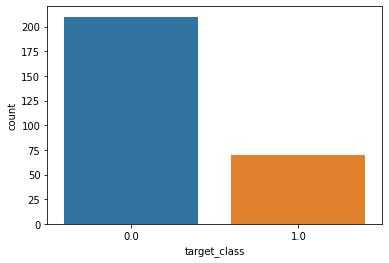

In [ ]:
sns.countplot(x=df["target_class"])


print(f'{df.target_class[df.target_class==1].count()/df.target_class.count()*100:.2f} % of samples are Attentive (1)')

In [ ]:
X = df.drop(['target_class'], axis = 1)
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=18, stratify=y) #stratify=y

print(f"""\
X_train: {X_train.shape}\n\
X_test: {X_test.shape}\n\
y_train: {y_train.shape}\n
y_train_counts:\n{y_train.value_counts()}\n
y_test: {y_test.shape}\n
y_test_counts:\n{y_test.value_counts()}\n
""")

X_train: (210, 100)
X_test: (70, 100)
y_train: (210,)

y_train_counts:
0.0    157
1.0     53
Name: target_class, dtype: int64

y_test: (70,)

y_test_counts:
0.0    53
1.0    17
Name: target_class, dtype: int64




## Parte 2: Balanceamento dos dados

In [ ]:
# Balancing data - oversampling minority
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)

# for i in y_train:
#     if (i == "M")
#         M = M + 1

# print("M")


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



### Scaling

In [ ]:
# Scaling
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

## Parte 3: Treinamento

In [ ]:
y_train_A = np.count_nonzero(y_train == 1)
y_train_R = (y_train == 0).sum()

print(f"""\
X_train: {X_train.shape}\n\
X_test: {X_test.shape}\n\
y_train: {y_train.shape}\n
y_train_A: {y_train_A}\n
y_train_R: {y_train_R}\n
y_test: {y_test.shape}\n
y_test_counts:\n{y_test.value_counts()}\n
""")

X_train: (314, 100)
X_test: (70, 100)
y_train: (314,)

y_train_A: 157

y_train_R: 157

y_test: (70,)

y_test_counts:
0.0    53
1.0    17
Name: target_class, dtype: int64




In [ ]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
        #  "Decision Tree": DecisionTreeClassifier(),
        #  "Naive Bayes": GaussianNB(),
        #  "ExtraTreesClassifier": ExtraTreesClassifier(),
         "SupportVectorMachine": svm.SVC(),
           "XGB Classifier": XGBClassifier(),
          "Random Forest": RandomForestClassifier(n_estimators=200,
                                                    max_features="sqrt")} 
                                                  
        


# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
   
    """
   Fits and evaluates given machine learning models.
   models: a dict of different Scikit_Learn machine learning models
   X_train: training data (no labels)
   X_test: testing data (no labels)
   y_train: training labels
   y_test: test labels
   """ 
    # Set random seed
    np.random.seed(18)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit model to data
        model.fit(X_train, y_train)

        if name == "MultiLayerPerceptron":
            model_scores[name] = model.score(X_test, y_test)
        
        else:
            # Evaluate model and append its score to model_scores
            model_scores[name] = cross_val_score(model,
                                                    X_test,
                                                    y_test,
                                                scoring='accuracy',
                                                cv=5
                                                ).mean()
            y_pred = model.predict(X_test)
            print(confusion_matrix(y_test,y_pred))
            print("Classification Report of: ", name)
            print(classification_report(y_test, y_pred))



    return model_scores

In [ ]:
model_scores = fit_and_score(models,X_train,X_test,y_train,y_test)

model_scores

[[47  6]
 [ 4 13]]
Classification Report of:  Logistic Regression
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90        53
         1.0       0.68      0.76      0.72        17

    accuracy                           0.86        70
   macro avg       0.80      0.83      0.81        70
weighted avg       0.86      0.86      0.86        70

[[41 12]
 [ 5 12]]
Classification Report of:  KNN
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83        53
         1.0       0.50      0.71      0.59        17

    accuracy                           0.76        70
   macro avg       0.70      0.74      0.71        70
weighted avg       0.80      0.76      0.77        70

[[42 11]
 [ 5 12]]
Classification Report of:  SupportVectorMachine
              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84        53
         1.0       0.52      0.71      0.60        17


{'KNN': 0.8285714285714286,
 'Logistic Regression': 0.7428571428571429,
 'Random Forest': 0.7857142857142857,
 'SupportVectorMachine': 0.7571428571428572,
 'XGB Classifier': 0.8}

In [ ]:
np.random.seed(18)

# Create a hyperparameter grid for XGB Classifier
xgb_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ]}


# Setup random hyperparameter search for XGB Classifier
rs_xgb = RandomizedSearchCV(XGBClassifier(),
                                param_distributions=xgb_grid,
                                cv=2,
                                n_iter=100,
                                verbose=0
                               )

# Fit random hyperparameter search model for XGB Classifier
rs_xgb.fit(X_train, y_train)

# Find best hyperparamaters
rs_xgb.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1}

In [ ]:
# Final model - XGBClassifier
model = RandomForestClassifier()
# model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

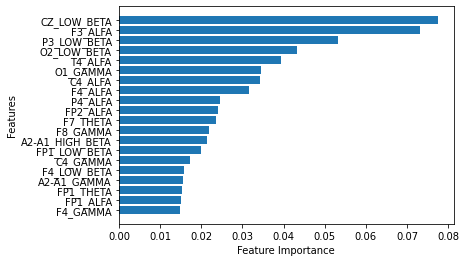

In [ ]:
# Helper function for plotting feature importance
def plot_features(columns, importances,n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    # Plot dataframe
    fix, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()
    
plot_features(df.drop(['target_class'],axis=1).columns, model.feature_importances_)

## Parte 3.1: Hyperparameter Tuning de Máquina de Vetores de Suporte




In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [ ]:
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

In [ ]:
print(grid.best_estimator_)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))#Output

[[50  3]
 [ 4 13]]
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93        53
         1.0       0.81      0.76      0.79        17

    accuracy                           0.90        70
   macro avg       0.87      0.85      0.86        70
weighted avg       0.90      0.90      0.90        70



## Parte 3.2: Hyperparameter Tuning de Floresta Aleatória

In [ ]:
rf = RandomForestClassifier(random_state = 42)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [ ]:
best_random = RandomForestClassifier(
                                    bootstrap= False,
                                    max_depth= 20,
                                    max_features= 'auto',
                                    min_samples_leaf= 1,
                                    min_samples_split= 2,
                                    n_estimators= 1800)
best_random.fit(X_train, y_train)
random_accuracy = best_random.predict(X_test)
# random_accuracy = rf_random.predict(X_test)
print(confusion_matrix(y_test,random_accuracy))
print(classification_report(y_test,random_accuracy))#Output

[[52  1]
 [ 1 16]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        53
         1.0       0.94      0.94      0.94        17

    accuracy                           0.97        70
   macro avg       0.96      0.96      0.96        70
weighted avg       0.97      0.97      0.97        70



## Parte 4: Visualização de dados

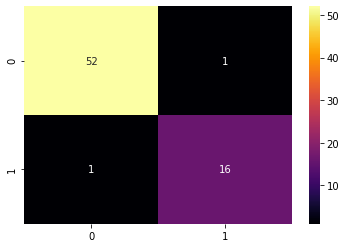

In [ ]:
sns.heatmap(confusion_matrix(y_test, random_accuracy), annot=True, fmt='d', cmap="inferno")

0         FP1_ALFA
1      A2-A1_GAMMA
2         FP2_ALFA
3        FP2_THETA
4        FP1_THETA
5          F8_ALFA
6      O1_LOW_BETA
7       A2-A1_ALFA
8          F7_ALFA
9      P4_LOW_BETA
10     A2-A1_THETA
11        T6_GAMMA
12     T5_LOW_BETA
13       FP1_GAMMA
14    PZ_HIGH_BETA
15     PZ_LOW_BETA
16        F8_THETA
17     P3_LOW_BETA
18        O2_THETA
19    O1_HIGH_BETA
Name: features, dtype: object


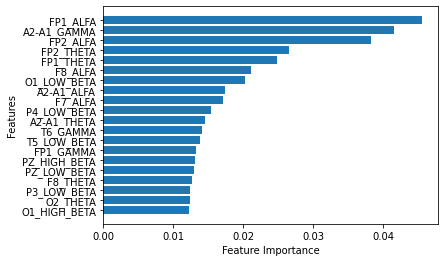

In [ ]:
# Helper function for plotting feature importance
def plot_features(columns, importances,n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    # Plot dataframe
    fix, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()
    
    print(df["features"][:20])
    
plot_features(df.drop(['target_class'],axis=1).columns, best_random.feature_importances_)

In [ ]:
df['target_class'] = df['target_class'].astype(str) 
df['target_class'] = df['target_class'].replace('0.0','Relaxed')
df['target_class'] = df['target_class'].replace('1.0','Attentive')
df

,FP1_THETA,FP1_ALFA,FP1_LOW_BETA,FP1_HIGH_BETA,FP1_GAMMA,FP2_THETA,FP2_ALFA,FP2_LOW_BETA,FP2_HIGH_BETA,FP2_GAMMA,F3_THETA,F3_ALFA,F3_LOW_BETA,F3_HIGH_BETA,F3_GAMMA,F4_THETA,F4_ALFA,F4_LOW_BETA,F4_HIGH_BETA,F4_GAMMA,F7_THETA,F7_ALFA,F7_LOW_BETA,F7_HIGH_BETA,F7_GAMMA,F8_THETA,F8_ALFA,F8_LOW_BETA,F8_HIGH_BETA,F8_GAMMA,T3_THETA,T3_ALFA,T3_LOW_BETA,T3_HIGH_BETA,T3_GAMMA,T4_THETA,T4_ALFA,T4_LOW_BETA,T4_HIGH_BETA,T4_GAMMA,...,P3_ALFA,P3_LOW_BETA,P3_HIGH_BETA,P3_GAMMA,P4_THETA,P4_ALFA,P4_LOW_BETA,P4_HIGH_BETA,P4_GAMMA,O1_THETA,O1_ALFA,O1_LOW_BETA,O1_HIGH_BETA,O1_GAMMA,O2_THETA,O2_ALFA,O2_LOW_BETA,O2_HIGH_BETA,O2_GAMMA,FZ_THETA,FZ_ALFA,FZ_LOW_BETA,FZ_HIGH_BETA,FZ_GAMMA,CZ_THETA,CZ_ALFA,CZ_LOW_BETA,CZ_HIGH_BETA,CZ_GAMMA,PZ_THETA,PZ_ALFA,PZ_LOW_BETA,PZ_HIGH_BETA,PZ_GAMMA,A2-A1_THETA,A2-A1_ALFA,A2-A1_LOW_BETA,A2-A1_HIGH_BETA,A2-A1_GAMMA,target_class
0,0.003122,0.000746,0.001290,0.003108,0.000984,0.005411,0.001114,0.001699,0.003875,0.001397,0.007081,0.001243,0.002075,0.004681,0.001687,0.005092,0.001526,0.002358,0.004979,0.001751,0.013285,0.001435,0.001856,0.003119,0.001677,0.007875,0.001295,0.001836,0.003530,0.001795,0.008934,0.001348,0.002278,0.004970,0.001892,0.003524,0.001277,0.001832,0.004609,0.001419,...,0.001182,0.001713,0.006912,0.001667,0.004009,0.001435,0.002115,0.010475,0.001942,0.004973,0.001485,0.002685,0.008420,0.002087,0.004814,0.001740,0.004600,0.018207,0.002638,0.005512,0.001485,0.002350,0.004953,0.001717,0.005453,0.004913,0.002723,0.004240,0.001982,0.004638,0.001380,0.001883,0.007343,0.001822,0.000364,0.000256,0.000186,0.000429,0.000132,Relaxed
1,0.003605,0.000666,0.001151,0.003855,0.001076,0.006041,0.000956,0.001577,0.004728,0.001484,0.005199,0.001226,0.001922,0.006022,0.002006,0.005399,0.001502,0.002050,0.005927,0.001932,0.014417,0.001468,0.001560,0.004118,0.001599,0.007888,0.001246,0.001695,0.004136,0.001872,0.006925,0.001207,0.001996,0.004942,0.002118,0.005612,0.001127,0.001300,0.005156,0.001649,...,0.000994,0.001202,0.005752,0.001926,0.005782,0.001071,0.001407,0.009802,0.002030,0.005364,0.001086,0.001806,0.008943,0.002296,0.006755,0.001155,0.003045,0.024074,0.002835,0.005451,0.001478,0.002036,0.005918,0.001911,0.006511,0.004349,0.002591,0.005397,0.002185,0.006095,0.001058,0.001480,0.006026,0.001975,0.000437,0.000203,0.000169,0.000577,0.000147,Relaxed
2,0.003238,0.000703,0.001059,0.003332,0.001057,0.006116,0.001001,0.001324,0.004140,0.001483,0.004321,0.001103,0.001612,0.005074,0.001775,0.004820,0.001189,0.001907,0.005712,0.001838,0.012378,0.001539,0.001991,0.003163,0.001619,0.010413,0.001356,0.001481,0.003918,0.001762,0.008324,0.001123,0.002592,0.005189,0.002051,0.003411,0.000834,0.001318,0.005128,0.001504,...,0.000915,0.001321,0.005836,0.001688,0.004248,0.000947,0.001502,0.008389,0.001870,0.003866,0.000950,0.001317,0.005679,0.001984,0.005004,0.000986,0.001910,0.012841,0.002349,0.004606,0.001226,0.001920,0.005680,0.001798,0.005879,0.004560,0.002276,0.004939,0.002033,0.004761,0.000913,0.001415,0.006110,0.001771,0.000414,0.000258,0.000201,0.000497,0.000127,Relaxed
3,0.002924,0.000697,0.001280,0.003898,0.001035,0.005723,0.000899,0.001609,0.004823,0.001454,0.004187,0.001242,0.002095,0.006025,0.001800,0.004271,0.001320,0.002246,0.006477,0.001851,0.010359,0.001390,0.002052,0.003823,0.001610,0.005576,0.001145,0.001677,0.004644,0.001761,0.007544,0.001525,0.002410,0.004631,0.001822,0.004074,0.000970,0.001520,0.005759,0.001425,...,0.001277,0.001668,0.006309,0.001813,0.004276,0.001228,0.001840,0.011564,0.001965,0.004358,0.001231,0.002093,0.010676,0.002403,0.005381,0.001134,0.003777,0.029824,0.003036,0.004349,0.001334,0.002226,0.006431,0.001825,0.005601,0.004236,0.002740,0.005881,0.002097,0.004737,0.001361,0.001626,0.006907,0.001866,0.000388,0.000225,0.000208,0.000738,0.000156,Relaxed
4,0.002708,0.000764,0.001208,0.003596,0.001209,0.004032,0.000965,0.001529,0.004449,0.001588,0.004251,0.001402,0.001964,0.005743,0.002145,0.004798,0.001690,0.002125,0.006132,0.002167,0.011958,0.001320,0.001689,0.003542,0.001631,0.009049,0.001480,0.001

In [ ]:
grupo = df.groupby(['target_class']) 

In [ ]:
frequencies_labels = ['THETA', 'ALFA', 'LOW_BETA' ,'HIGH_BETA' ,'GAMMA']

for label in frequencies_labels:
        print(df.filter(like=label).columns)


Index(['FP1_THETA', 'FP2_THETA', 'F3_THETA', 'F4_THETA', 'F7_THETA',
       'F8_THETA', 'T3_THETA', 'T4_THETA', 'C3_THETA', 'C4_THETA', 'T5_THETA',
       'T6_THETA', 'P3_THETA', 'P4_THETA', 'O1_THETA', 'O2_THETA', 'FZ_THETA',
       'CZ_THETA', 'PZ_THETA', 'A2-A1_THETA'],
      dtype='object')
Index(['FP1_ALFA', 'FP2_ALFA', 'F3_ALFA', 'F4_ALFA', 'F7_ALFA', 'F8_ALFA',
       'T3_ALFA', 'T4_ALFA', 'C3_ALFA', 'C4_ALFA', 'T5_ALFA', 'T6_ALFA',
       'P3_ALFA', 'P4_ALFA', 'O1_ALFA', 'O2_ALFA', 'FZ_ALFA', 'CZ_ALFA',
       'PZ_ALFA', 'A2-A1_ALFA'],
      dtype='object')
Index(['FP1_LOW_BETA', 'FP2_LOW_BETA', 'F3_LOW_BETA', 'F4_LOW_BETA',
       'F7_LOW_BETA', 'F8_LOW_BETA', 'T3_LOW_BETA', 'T4_LOW_BETA',
       'C3_LOW_BETA', 'C4_LOW_BETA', 'T5_LOW_BETA', 'T6_LOW_BETA',
       'P3_LOW_BETA', 'P4_LOW_BETA', 'O1_LOW_BETA', 'O2_LOW_BETA',
       'FZ_LOW_BETA', 'CZ_LOW_BETA', 'PZ_LOW_BETA', 'A2-A1_LOW_BETA'],
      dtype='object')
Index(['FP1_HIGH_BETA', 'FP2_HIGH_BETA', 'F3_HIGH_BETA', 'F4_HIGH

In [ ]:
ex_vars = [ ['FP1_THETA', 'FP2_THETA', 'F3_THETA', 'F4_THETA', 'F7_THETA',
       'F8_THETA', 'T3_THETA', 'T4_THETA', 'C3_THETA', 'C4_THETA', 'T5_THETA',
       'T6_THETA', 'P3_THETA', 'P4_THETA', 'O1_THETA', 'O2_THETA', 'FZ_THETA',
       'CZ_THETA', 'PZ_THETA', 'A2-A1_THETA'],
['FP1_ALFA', 'FP2_ALFA', 'F3_ALFA', 'F4_ALFA', 'F7_ALFA', 'F8_ALFA',
       'T3_ALFA', 'T4_ALFA', 'C3_ALFA', 'C4_ALFA', 'T5_ALFA', 'T6_ALFA',
       'P3_ALFA', 'P4_ALFA', 'O1_ALFA', 'O2_ALFA', 'FZ_ALFA', 'CZ_ALFA',
       'PZ_ALFA', 'A2-A1_ALFA'],
['FP1_LOW_BETA', 'FP2_LOW_BETA', 'F3_LOW_BETA', 'F4_LOW_BETA',
       'F7_LOW_BETA', 'F8_LOW_BETA', 'T3_LOW_BETA', 'T4_LOW_BETA',
       'C3_LOW_BETA', 'C4_LOW_BETA', 'T5_LOW_BETA', 'T6_LOW_BETA',
       'P3_LOW_BETA', 'P4_LOW_BETA', 'O1_LOW_BETA', 'O2_LOW_BETA',
       'FZ_LOW_BETA', 'CZ_LOW_BETA', 'PZ_LOW_BETA', 'A2-A1_LOW_BETA'],
['FP1_HIGH_BETA', 'FP2_HIGH_BETA', 'F3_HIGH_BETA', 'F4_HIGH_BETA',
       'F7_HIGH_BETA', 'F8_HIGH_BETA', 'T3_HIGH_BETA', 'T4_HIGH_BETA',
       'C3_HIGH_BETA', 'C4_HIGH_BETA', 'T5_HIGH_BETA', 'T6_HIGH_BETA',
       'P3_HIGH_BETA', 'P4_HIGH_BETA', 'O1_HIGH_BETA', 'O2_HIGH_BETA',
       'FZ_HIGH_BETA', 'CZ_HIGH_BETA', 'PZ_HIGH_BETA', 'A2-A1_HIGH_BETA'],
['FP1_GAMMA', 'FP2_GAMMA', 'F3_GAMMA', 'F4_GAMMA', 'F7_GAMMA',
       'F8_GAMMA', 'T3_GAMMA', 'T4_GAMMA', 'C3_GAMMA', 'C4_GAMMA', 'T5_GAMMA',
       'T6_GAMMA', 'P3_GAMMA', 'P4_GAMMA', 'O1_GAMMA', 'O2_GAMMA', 'FZ_GAMMA',
       'CZ_GAMMA', 'PZ_GAMMA', 'A2-A1_GAMMA'] ]



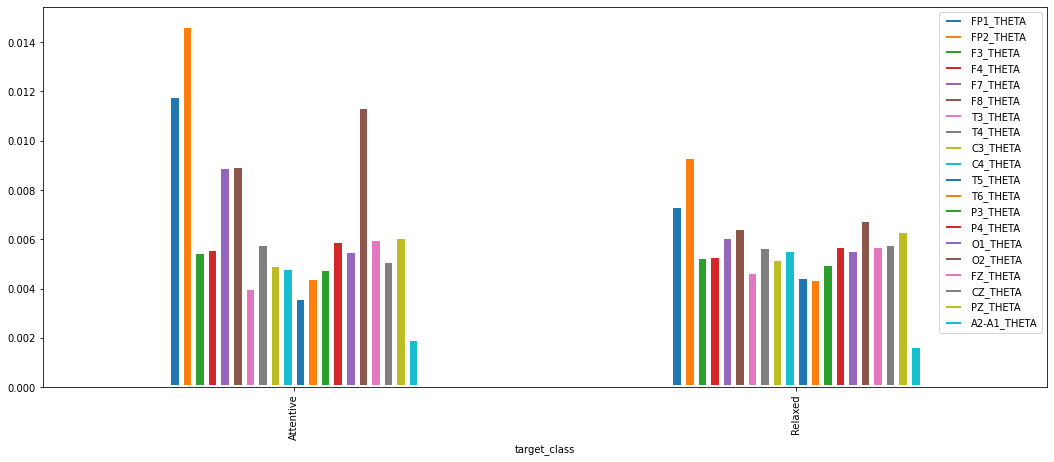

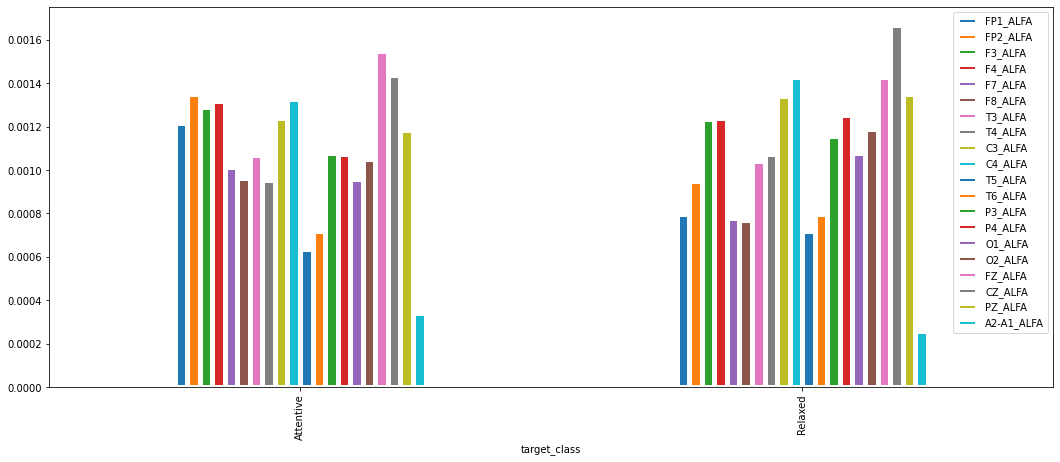

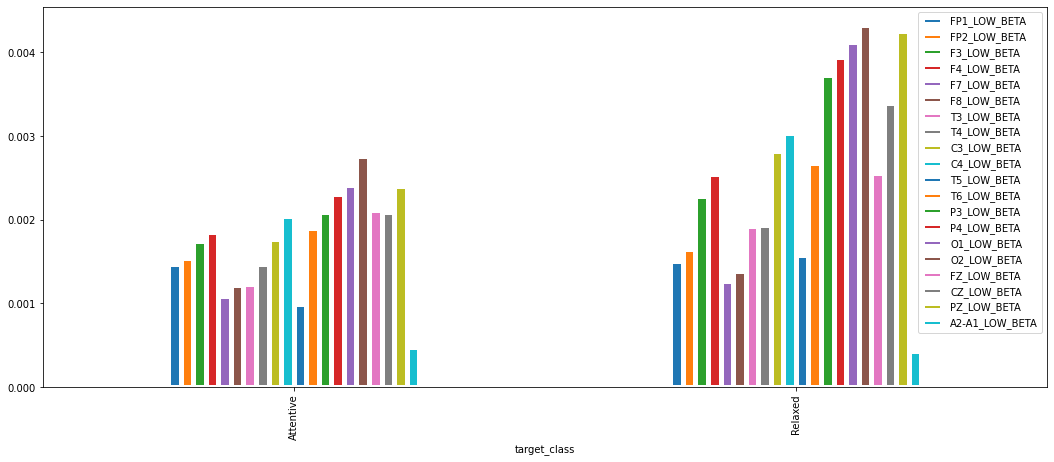

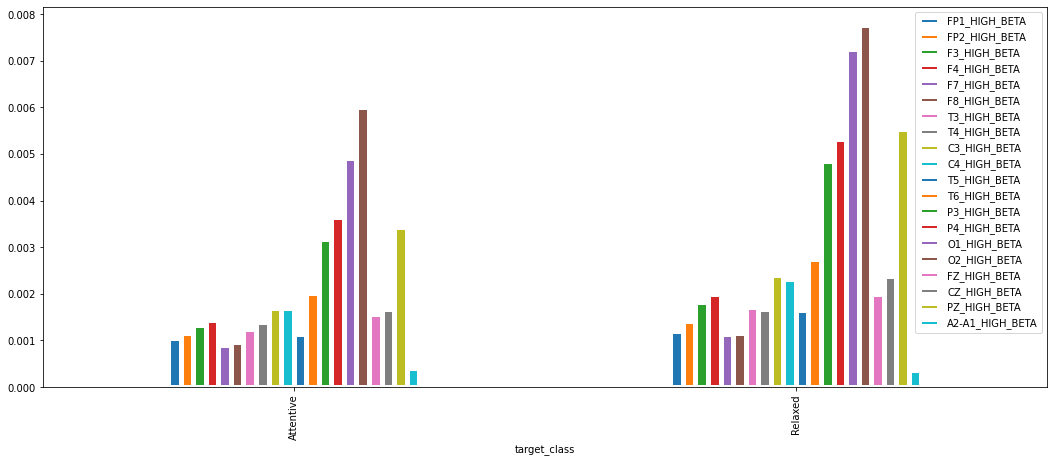

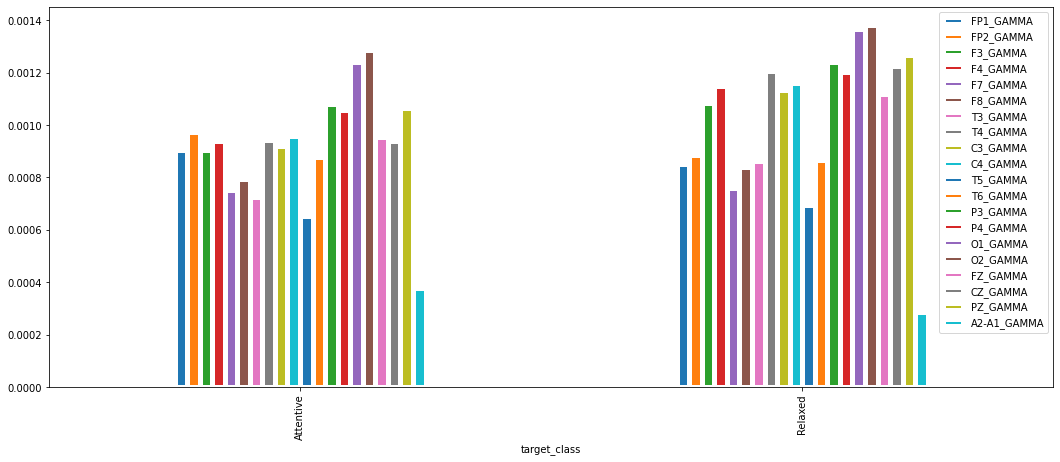

In [ ]:
for _vars in ex_vars:
    mean_bar = df.groupby('target_class')[_vars].mean()
    mean_bar.plot(kind="bar",figsize=(18,7), edgecolor='white', linewidth=5, position = 0.5)

In [ ]:
vars = df.columns

In [ ]:
mean_bar = df.groupby('target_class')[vars].mean()

In [ ]:
mean_bar

,FP1_THETA,FP1_ALFA,FP1_LOW_BETA,FP1_HIGH_BETA,FP1_GAMMA,FP2_THETA,FP2_ALFA,FP2_LOW_BETA,FP2_HIGH_BETA,FP2_GAMMA,F3_THETA,F3_ALFA,F3_LOW_BETA,F3_HIGH_BETA,F3_GAMMA,F4_THETA,F4_ALFA,F4_LOW_BETA,F4_HIGH_BETA,F4_GAMMA,F7_THETA,F7_ALFA,F7_LOW_BETA,F7_HIGH_BETA,F7_GAMMA,F8_THETA,F8_ALFA,F8_LOW_BETA,F8_HIGH_BETA,F8_GAMMA,T3_THETA,T3_ALFA,T3_LOW_BETA,T3_HIGH_BETA,T3_GAMMA,T4_THETA,T4_ALFA,T4_LOW_BETA,T4_HIGH_BETA,T4_GAMMA,...,P3_ALFA,P3_LOW_BETA,P3_HIGH_BETA,P3_GAMMA,P4_THETA,P4_ALFA,P4_LOW_BETA,P4_HIGH_BETA,P4_GAMMA,O1_THETA,O1_ALFA,O1_LOW_BETA,O1_HIGH_BETA,O1_GAMMA,O2_THETA,O2_ALFA,O2_LOW_BETA,O2_HIGH_BETA,O2_GAMMA,FZ_THETA,FZ_ALFA,FZ_LOW_BETA,FZ_HIGH_BETA,FZ_GAMMA,CZ_THETA,CZ_ALFA,CZ_LOW_BETA,CZ_HIGH_BETA,CZ_GAMMA,PZ_THETA,PZ_ALFA,PZ_LOW_BETA,PZ_HIGH_BETA,PZ_GAMMA,A2-A1_THETA,A2-A1_ALFA,A2-A1_LOW_BETA,A2-A1_HIGH_BETA,A2-A1_GAMMA,target_class
target_class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.007401,0.000795,0.001505,0.00121,0.000852,0.009372,0.00095,0.001652,0.001425,0.000886,0.005326,0.001235,0.002283,0.001816,0.001084,0.005371,0.001240,0.002542,0.002005,0.001148,0.006145,0.000779,0.001266,0.001129,0.000760,0.006506,0.000770,0.001383,0.001166,0.000839,0.004731,0.001040,0.001922,0.001724,0.000861,0.005741,0.001072,0.001941,0.001669,0.001207,...,0.001157,0.003734,0.004843,0.001239,0.005753,0.001254,0.003947,0.005324,0.001202,0.005619,0.001076,0.004129,0.007247,0.001368,0.006836,0.001189,0.004330,0.007768,0.001382,0.005769,0.001429,0.002554,0.002004,0.001118,0.005858,0.001669,0.003392,0.002383,0.001224,0.006395,0.001351,0.004260,0.005528,0.001265,0.001701,0.000258,0.000426,0.000367,0.000287,0.0
1.0,0.011870,0.001215,0.001475,0.00106,0.000904,0.014704,0.00135,0.001541,0.001171,0.000974,0.005517,0.001289,0.001751,0.001341,0.000905,0.005652,0.001319,0.001858,0.001449,0.000939,0.008954,0.001015,0.001085,0.000896,0.000752,0.009018,0.000963,0.001220,0.000972,0.000794,0.004079,0.001068,0.001237,0.001242,0.000724,0.005835,0.000954,0.001477,0.001394,0.000944,...,0.001080,0.002092,0.003170,0.001079,0.005962,0.001072,0.002310,0.003647,0.001057,0.005571,0.000957,0.002409,0.004906,0.001240,0.011411,0.001051,0.002763,0.005997,0.001287,0.006043,0.001547,0.002112,0.001561,0.000953,0.005161,0.001438,0.002088,0.001670,0.000939,0.006133,0.001182,0.002404,0.003432,0.001065,0.002011,0.000344,0.000483,0.000415,0.000379,1.0


In [ ]:
electrodes_labels = ['FP1', 'FP2', 'F3', 'F4', 'F7',
       'F8', 'T3', 'T4', 'C3', 'C4', 'T5',
       'T6', 'P3', 'P4', 'O1', 'O2', 'FZ',
       'CZ', 'PZ', 'A2-A1'] 


for label in electrodes_labels:
        print(df.filter(like=label).columns)

Index(['FP1_THETA', 'FP1_ALFA', 'FP1_LOW_BETA', 'FP1_HIGH_BETA', 'FP1_GAMMA'], dtype='object')
Index(['FP2_THETA', 'FP2_ALFA', 'FP2_LOW_BETA', 'FP2_HIGH_BETA', 'FP2_GAMMA'], dtype='object')
Index(['F3_THETA', 'F3_ALFA', 'F3_LOW_BETA', 'F3_HIGH_BETA', 'F3_GAMMA'], dtype='object')
Index(['F4_THETA', 'F4_ALFA', 'F4_LOW_BETA', 'F4_HIGH_BETA', 'F4_GAMMA'], dtype='object')
Index(['F7_THETA', 'F7_ALFA', 'F7_LOW_BETA', 'F7_HIGH_BETA', 'F7_GAMMA'], dtype='object')
Index(['F8_THETA', 'F8_ALFA', 'F8_LOW_BETA', 'F8_HIGH_BETA', 'F8_GAMMA'], dtype='object')
Index(['T3_THETA', 'T3_ALFA', 'T3_LOW_BETA', 'T3_HIGH_BETA', 'T3_GAMMA'], dtype='object')
Index(['T4_THETA', 'T4_ALFA', 'T4_LOW_BETA', 'T4_HIGH_BETA', 'T4_GAMMA'], dtype='object')
Index(['C3_THETA', 'C3_ALFA', 'C3_LOW_BETA', 'C3_HIGH_BETA', 'C3_GAMMA'], dtype='object')
Index(['C4_THETA', 'C4_ALFA', 'C4_LOW_BETA', 'C4_HIGH_BETA', 'C4_GAMMA'], dtype='object')
Index(['T5_THETA', 'T5_ALFA', 'T5_LOW_BETA', 'T5_HIGH_BETA', 'T5_GAMMA'], dtype='object')


In [ ]:
mean_bar

,FP1_GAMMA,FP2_GAMMA,F3_GAMMA,F4_GAMMA,F7_GAMMA,F8_GAMMA,T3_GAMMA,T4_GAMMA,C3_GAMMA,C4_GAMMA,T5_GAMMA,T6_GAMMA,P3_GAMMA,P4_GAMMA,O1_GAMMA,O2_GAMMA,FZ_GAMMA,CZ_GAMMA,PZ_GAMMA,A2-A1_GAMMA
target_class,,,,,,,,,,,,,,,,,,,,
Attentive,0.000904,0.000974,0.000905,0.000939,0.000752,0.000794,0.000724,0.000944,0.000920,0.000956,0.000654,0.000879,0.001079,0.001057,0.001240,0.001287,0.000953,0.000939,0.001065,0.000379
Relaxed,0.000852,0.000886,0.001084,0.001148,0.000760,0.000839,0.000861,0.001207,0.001133,0.001159,0.000695,0.000867,0.001239,0.001202,0.001368,0.001382,0.001118,0.001224,0.001265,0.000287


In [ ]:
elec_group = [ ['FP1_THETA', 'FP1_ALFA', 'FP1_LOW_BETA', 'FP1_HIGH_BETA', 'FP1_GAMMA'], 
['FP2_THETA', 'FP2_ALFA', 'FP2_LOW_BETA', 'FP2_HIGH_BETA', 'FP2_GAMMA'], 
['F3_THETA', 'F3_ALFA', 'F3_LOW_BETA', 'F3_HIGH_BETA', 'F3_GAMMA'], 
['F4_THETA', 'F4_ALFA', 'F4_LOW_BETA', 'F4_HIGH_BETA', 'F4_GAMMA'], 
['F7_THETA', 'F7_ALFA', 'F7_LOW_BETA', 'F7_HIGH_BETA', 'F7_GAMMA'], 
['F8_THETA', 'F8_ALFA', 'F8_LOW_BETA', 'F8_HIGH_BETA', 'F8_GAMMA'], 
['T3_THETA', 'T3_ALFA', 'T3_LOW_BETA', 'T3_HIGH_BETA', 'T3_GAMMA'], 
['T4_THETA', 'T4_ALFA', 'T4_LOW_BETA', 'T4_HIGH_BETA', 'T4_GAMMA'], 
['C3_THETA', 'C3_ALFA', 'C3_LOW_BETA', 'C3_HIGH_BETA', 'C3_GAMMA'], 
['C4_THETA', 'C4_ALFA', 'C4_LOW_BETA', 'C4_HIGH_BETA', 'C4_GAMMA'], 
['T5_THETA', 'T5_ALFA', 'T5_LOW_BETA', 'T5_HIGH_BETA', 'T5_GAMMA'], 
['T6_THETA', 'T6_ALFA', 'T6_LOW_BETA', 'T6_HIGH_BETA', 'T6_GAMMA'], 
['P3_THETA', 'P3_ALFA', 'P3_LOW_BETA', 'P3_HIGH_BETA', 'P3_GAMMA'],
['P4_THETA', 'P4_ALFA', 'P4_LOW_BETA', 'P4_HIGH_BETA', 'P4_GAMMA'], 
['O1_THETA', 'O1_ALFA', 'O1_LOW_BETA', 'O1_HIGH_BETA', 'O1_GAMMA'], 
['O2_THETA', 'O2_ALFA', 'O2_LOW_BETA', 'O2_HIGH_BETA', 'O2_GAMMA'], 
['FZ_THETA', 'FZ_ALFA', 'FZ_LOW_BETA', 'FZ_HIGH_BETA', 'FZ_GAMMA'], 
['CZ_THETA', 'CZ_ALFA', 'CZ_LOW_BETA', 'CZ_HIGH_BETA', 'CZ_GAMMA'],
['PZ_THETA', 'PZ_ALFA', 'PZ_LOW_BETA', 'PZ_HIGH_BETA', 'PZ_GAMMA'], 
['A2-A1_THETA', 'A2-A1_ALFA', 'A2-A1_LOW_BETA', 'A2-A1_HIGH_BETA','A2-A1_GAMMA'] ]

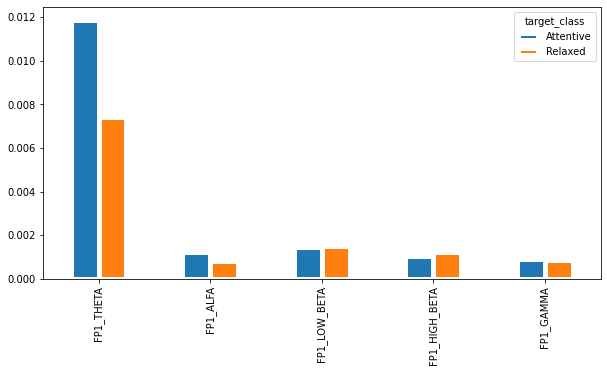

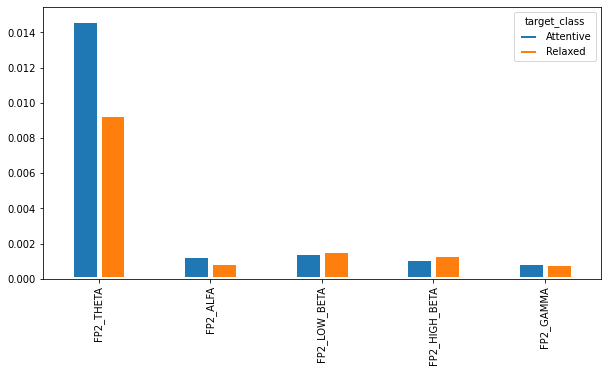

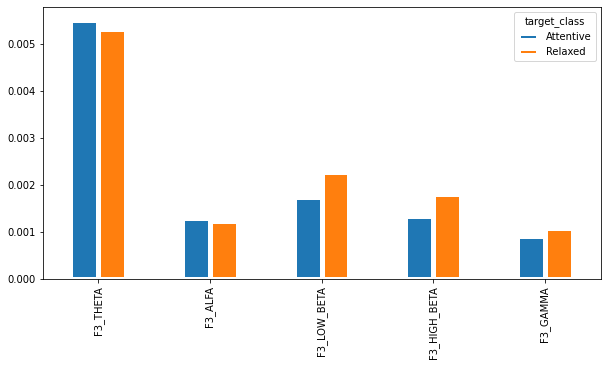

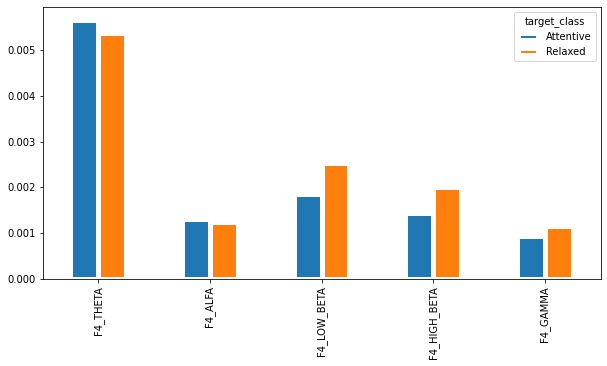

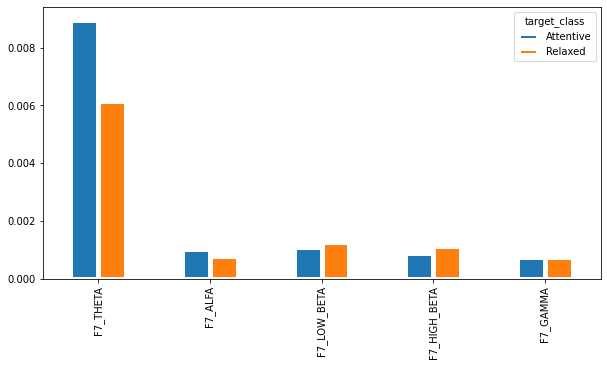

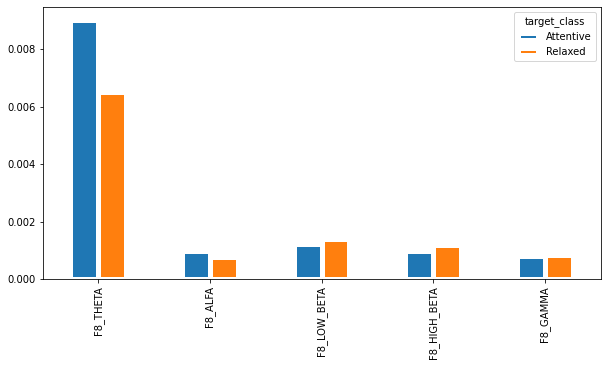

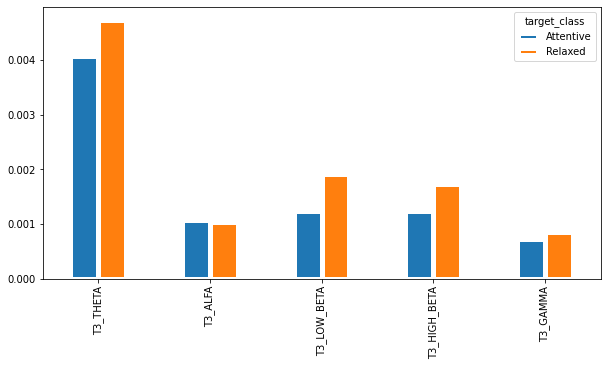

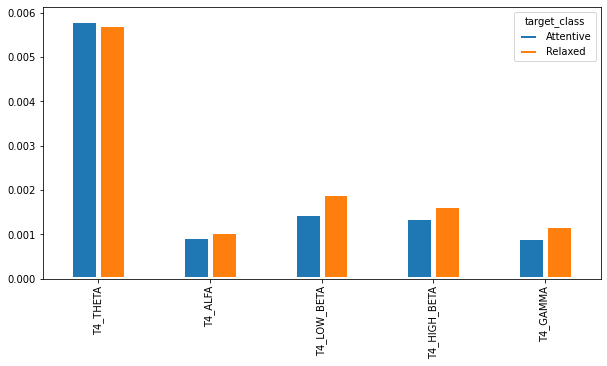

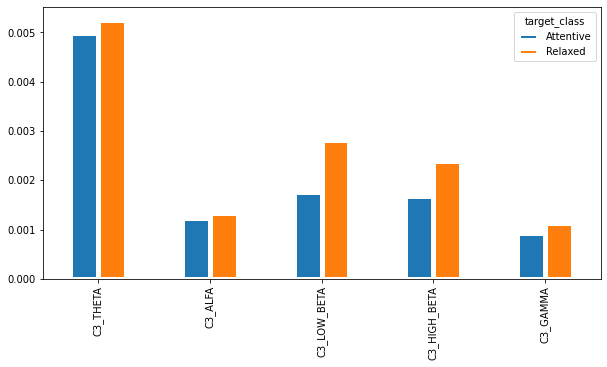

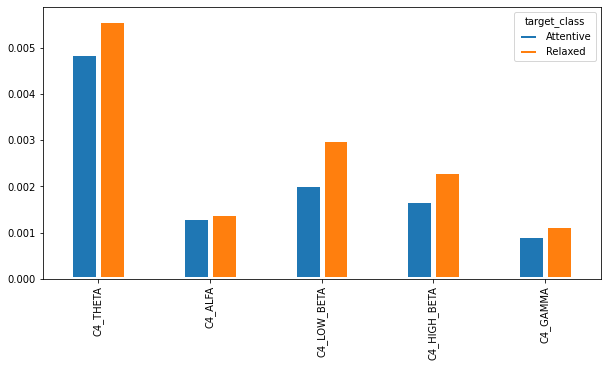

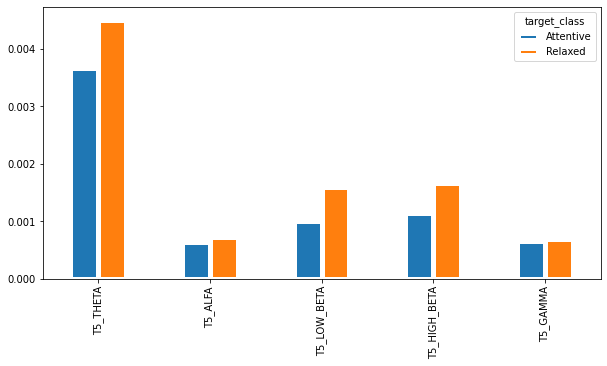

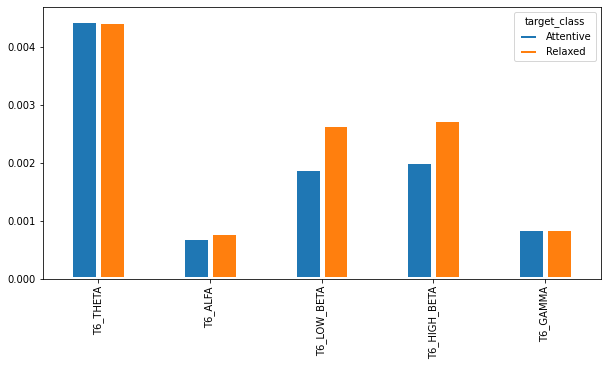

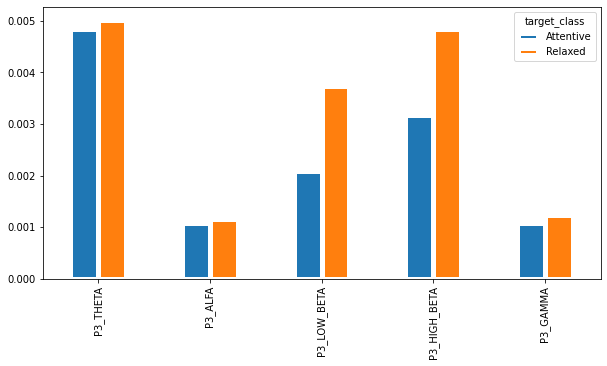

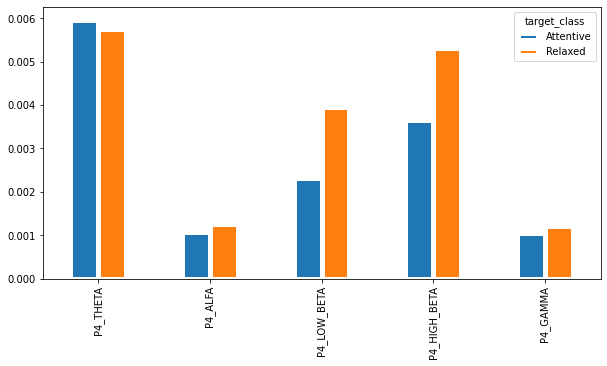

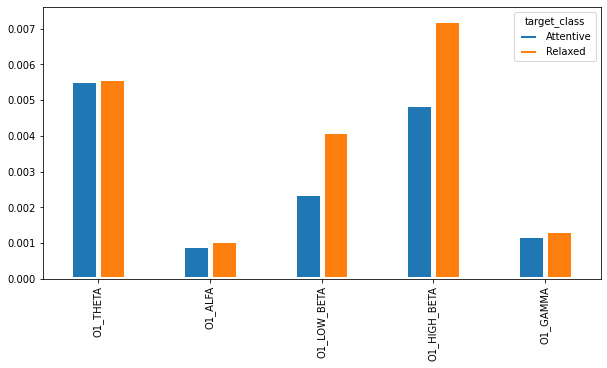

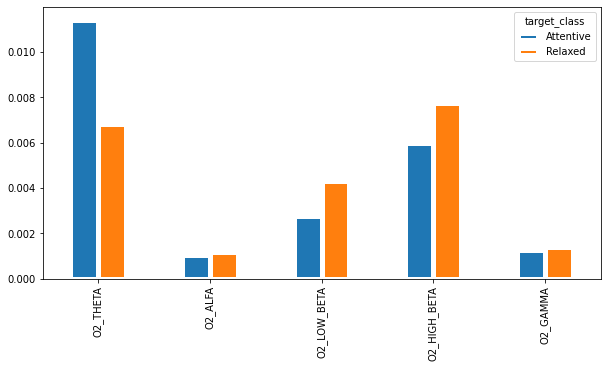

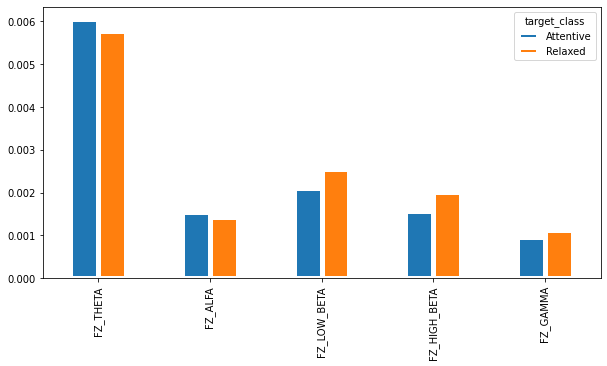

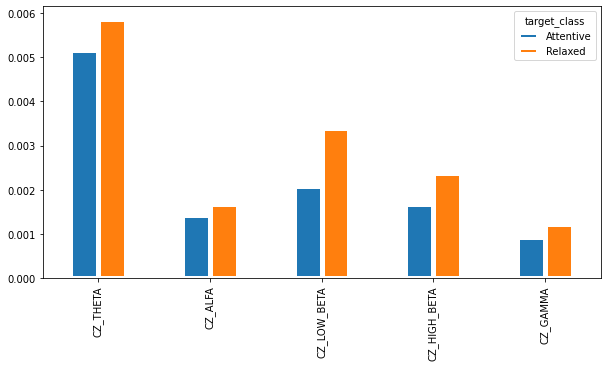

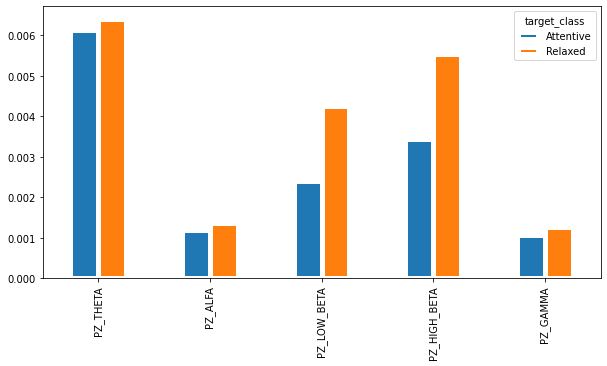

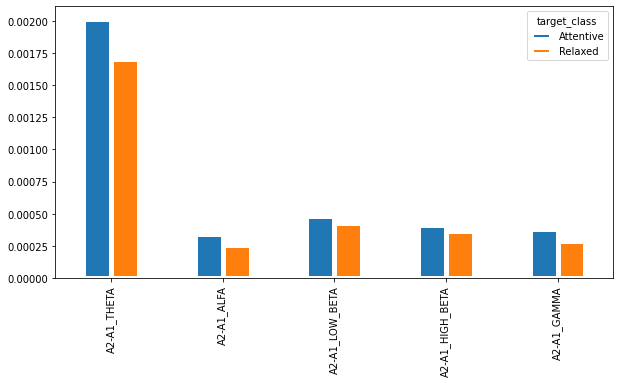

In [ ]:

for ex in elec_group:
    test=mean_bar[ex]
    test = pd.DataFrame(test).transpose()
    test.plot(kind="bar",figsize=(10,5), edgecolor='white', linewidth=5, position = 0.5)
